In [1]:
import numpy as np
import matplotlib.pyplot as plt

### To do:
- add marginal cost in the greedy controller
- plot instaneous path ratio
- Try with a different network
- Implement two player game

Later:
- use scipy csc for the adjencency graph
- Implement cars with probabilities
- Try on Fremont network
- Do optimal control


In [2]:
class network:
    def __init__(self, graph_dict):
        """
        Creating the network from dictionary
        """
        def create_connections(g):
            connections = np.zeros((1,2))
            for i in self.graph.keys():
                for j in self.graph[i]["connection"]:
                    connections = np.append(connections, [[i, j],], axis=0)
            connections = connections[1:]
            return connections
        
        def create_adj_line_graph(array):
            nb_links = array.shape[0]
            adj_matrix = np.zeros((nb_links,nb_links))
            for k in range(nb_links):
                adj_matrix[k][np.argwhere(array[:,0]==array[k][1])] = 1
            return adj_matrix
        
        # This dictionary is the graph
        self.graph = graph_dict
        self.connections = create_connections(self.graph)
        self.nb_links = self.connections.shape[0]
        self.__adj_matrix = create_adj_line_graph(self.connections)
        self.__mfd_set_up = False

    def set_up_mfd(self, v_max, x_max, c):
        """
        Set up macroscopic flow diagram to get travel time.
        """
        if not (self.is_valid_flow(x_max) & self.is_valid_flow(x_max) & self.is_valid_flow(x_max)):
            print("Incorrect vectors to set up to MFD")
            pass
        self.v_max = v_max
        self.x_max = x_max
        self.c = c
        self.__mfd_set_up = True

    def mfd_aux(self,x, v_max, x_max, c):
        if x == 0:
            return v_max
        if x >= x_max:
            return 0
        v = v_max*(1-np.exp((c/v_max) * (1-x_max/x)))
        return v
    
    def mfd(self,x, v_max, x_max, c):
        return x * self.mfd_aux(x, v_max, x_max, c)
    
    def update_matrix_from_with_mfd(self, mfd_v, P, des):
        """
        Given a stoachatics matrix, change it to take into account travel time on links.
        Change this function to implement congestion spill back.
        """
#         if not (self.is_valid_outflow_ratio(mfd_v) and self.is_valid_matrix_with_destination(P, des)):
#             print("Matrix or vector of travel time are not correct")
#             return -1
        matrix = - np.diag(np.ones(self.nb_links))
        for i in range(self.nb_links):
            matrix[i,:] = (matrix[i,:] + P[i,:]) * mfd_v[i]
        return matrix
        
    def update_flow_from_matrix_one_player(self, x, P, dt, des=-1):
        """
        One step of the flow dynamics given a stochastic matrix and a time step
        """
#         if not self.__mfd_set_up:
#             print("Please use set up MFD function before running the experiment")
#             return
#         if not self.is_valid_flow(x):
#             print("Flow vector x does not seems correctly defined")
#             return
#         if not self.is_valid_matrix_with_destination(P, des):
#             print("P does not seems to be a correct control matrix")
#             print(P)
#             return
        mfd_v = np.array([self.mfd_aux(x[i], self.v_max[i], self.x_max[i], self.c[i]) for i in range(self.nb_links)])
        matrix = self.update_matrix_from_with_mfd(mfd_v, P, des)
        x_t_1 = x + matrix.T @ x * dt
        return x_t_1
        
    def simulation_one_player(self, x0, nb_iteration, dt, controller, destination):
        """
        Simulate flow dynamics given a controller function that gives a stochastic matrix as a function of the flow allocation
        """
        x = x0
        # saving the results
        f = np.zeros((nb_iteration+1, g.nb_links))
        for t in range(nb_iteration):
            f[t] = x
            x = self.update_flow_from_matrix_one_player(x, controller(self, x), dt, destination)
        f[nb_iteration] = x
        return f
        
    def get_adj_matrix(self):
        """
        Return the adjency matrix of the line graph.
        """
        return self.__adj_matrix.copy()
        
    def get_mean_travel_time(self, x):
        """
        Give meanlife travel time on a link using the MFD
        """
        if not self.__mfd_set_up:
            print("Please use set up MFD function before running the experiment")
            return
        tt = np.zeros(self.nb_links)
        for i in range(self.nb_links):
            mfd_tmp = self.mfd_aux(x[i], self.v_max[i], self.x_max[i], self.c[i])
            if mfd_tmp == 0:
                tt[i] = 10**6
            else:
                tt[i] = 1/mfd_tmp
        return tt
        
    def get_weighted_matrix_aux(self, tt):
        """
        Give weighted_matrix given travel time on links
        """
        if not self.is_valid_flow(tt):
            print("Argument not valid, tt is not a vector of travel time")
            return
        matrix = g.get_adj_matrix()
        indices = np.nonzero(matrix)
        for i in range(len(indices[0])):
            j, k = indices[0][i], indices[1][i]
            matrix[j,k] = tt[k]
        return matrix
    
    def get_weighted_matrix(self, x):
        """
        Give weighted_matrix given flow on links
        """
        tt = self.get_mean_travel_time(x)
        return self.get_weighted_matrix_aux(tt)
    
    def plot_network(self):
        """
        Plot the network
        """
        %matplotlib inline
        links = np.zeros((self.nb_links, 4))
        for i in range(self.nb_links):
            links[i,:2] = self.graph[self.connections[i,0]]["location"]
            links[i,2:] = self.graph[self.connections[i,1]]["location"]
    
        plt.quiver(links[:, 0], links[:, 1], links[:, 2]-links[:, 0], links[:, 3]-links[:, 1], color="b", angles='xy', scale_units='xy', scale=1)
        plt.xlim([np.min(links[:, [0,2]])-0.5, np.max(links[:, [0,2]]) + 0.5])
        plt.ylim([np.min(links[:, [1,3]])-0.5, np.max(links[:, [1,3]]) + 0.5])
        plt.show()
        
    def plot_mfd(self, i):
        """
        Plot MFD for one link
        """
        %matplotlib inline
        if not isinstance(i, int):
            print("i should be an integer")
        if i>=self.nb_links or i<0:
            print("i should be in [0," + str(self.nb_links-1) + "]")
        values = np.arange(0, self.x_max[i], self.x_max[i]/100.)
        
        # change mfd_aux to mfd to get the mfd plot
        plt.plot(values, [self.mfd_aux(j, self.v_max[i], self.x_max[i], self.c[i]) for j in values], label="MFD of link " + str(i+1))
        plt.legend()
        plt.show()
    
    def plot_flow(self, x):
        """
        Plot flow results over time
        """
        %matplotlib inline
        if not isinstance(x, np.ndarray):
            print("Argument is not numpy array")
            return
        if not isinstance(x.shape,  tuple):
            print("Argument has not the correct shape")
            return
        n,m = x.shape
        if m!= self.nb_links:
            print("Shape should be (...," + str(self.nb_links) + "); it is " + str((n,m)))
            return
        for i in range(self.nb_links):
            plt.plot(x[:,i], label="flow on link " + str(i+1))
        plt.legend()
        plt.show()

    def is_valid_flow(self, x):
        """
        Test that a flow is valid: numpy array with int positive values
        """
        if not isinstance(x, np.ndarray):
            return False
        return (x.size == self.nb_links) & (x >= 0).all()
    
    def is_valid_matrix(self, P):
        """
        Test that P is a valid stochatisc matrix
        """
        # P should be an array
        if not isinstance(P, np.ndarray):
            return False
        
        # P should has the same size as the graph
        if not P.shape == self.__adj_matrix.shape:
            return False
        
        # P should has 0 where adj_matrix has 0
        if not np.all(P[self.__adj_matrix == 0]==0):
            return False
        
        # element of P should be >=0
        if not np.all(P>=0):
            return False
        return True
    
    def is_valid_matrix_with_destination(self, P, destination):
        if not self.is_valid_matrix(P):
            return False
        for i in range(self.nb_links):
            if not i in destination:
                if np.sum(P[i,:])!=1:
                    return False
        return True
    
    def is_valid_outflow_ratio(self, x):
        if not isinstance(x, np.ndarray):
            return False
        return (x.size == self.nb_links) & (x >= 0).all() & (x <= 1).all()
        

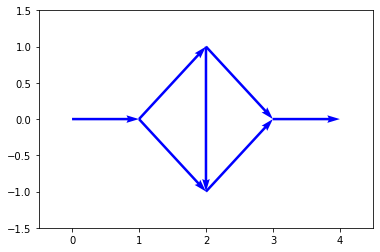

[[0. 1.]
 [1. 2.]
 [1. 3.]
 [2. 3.]
 [2. 4.]
 [3. 4.]
 [4. 5.]]


In [3]:
# Maybe we can set up the MFD in the dictionary
# creating the graph
graph_dict = {0: {"connection": {1}, "location": [0, 0]},
              1: {"connection": {2, 3}, "location": [1, 0]},
              2: {"connection": {3, 4}, "location": [2, 1]},
              3: {"connection": {4}, "location": [2, -1]},
              4: {"connection": {5}, "location": [3, 0]},
              5: {"connection": {}, "location": [4, 0]}}
g = network(graph_dict)
g.plot_network()
print(g.connections)

In [82]:
# Creating the MFD
vmax = 0.3 # 1/number of iteration to exit the link under free flow
xmax = 100 # max flow rate
c = 0.1

vmax_array = vmax * np.ones(g.nb_links)
xmax_array = xmax * np.ones(g.nb_links)
c_array = c * np.ones(g.nb_links)

# all vehicle should exist the network at the 
vmax_array[0] = 1
xmax_array[0] = 1000
c_array[0] = 1000
c_array[g.nb_links-1] = 0

# changing the parameters to see the results --> This is specific to the network considered
vmax_array[2] = 0.12
vmax_array[4] = 0.15

g.set_up_mfd(vmax_array, xmax_array, c_array)

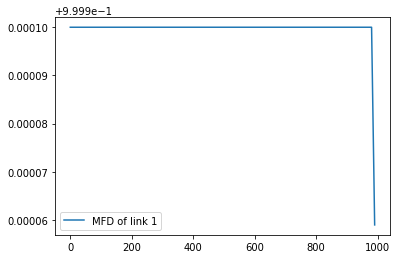

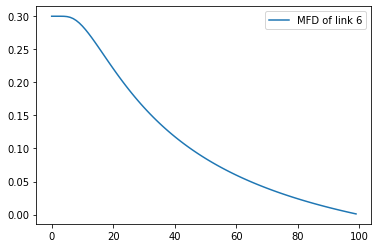

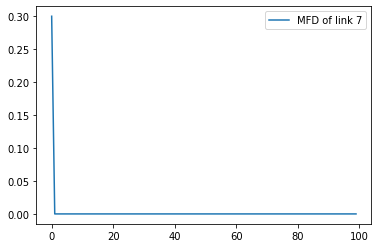

In [83]:
g.plot_mfd(0)
g.plot_mfd(5)
g.plot_mfd(6)

In [84]:
## THIS CELL IS SPECIFIC TO THE NETWORK CONSIDERED
import scipy.sparse as scs
u1 = 0.1
u2 = 0.5

def get_cost(f):
    return np.sum([np.sum(f[i,1:6]) for i in range(f.shape[0])])

# create a dummy controller
def dummy_controller(g, x, u1, u2):    
    matrix = g.get_adj_matrix()
    matrix[0][1] = 1 - u1
    matrix[0][2] = u1
    matrix[1][3] = 1 - u2
    matrix[1][4] = u2
    return matrix

def greedy_controller(g, x):
    adj = g.get_adj_matrix()
    G_sparse = scs.csr_matrix(g.get_weighted_matrix(x))
    cost, pred = scs.csgraph.shortest_path(G_sparse, method='auto', directed=True, return_predecessors=True, unweighted=False, overwrite=False)

    origin = 0
    tree = scs.csgraph.reconstruct_path(csgraph=G_sparse, predecessors=pred[origin], directed=True)
    t = np.nonzero(tree)
    matrix = np.zeros((g.nb_links,g.nb_links))

    i = 6
    while i != origin:
        j = np.argwhere(t[1]==i)[0][0]
        i = t[0][j]
        matrix[t[0][j], t[1][j]] = 1

    indices = np.argwhere(np.sum(matrix, axis=1)==0)[:,0]
    for k in indices:
        if k == 0:
            print("This is weird")
        if k == 1:
            origin = 1
            tree = scs.csgraph.reconstruct_path(csgraph=G_sparse, predecessors=pred[origin], directed=True)
            t = np.nonzero(tree)
            i = 6
            while i != origin:
                j = np.argwhere(t[1]==i)[0][0]
                i = t[0][j]
                matrix[t[0][j], t[1][j]] = 1
        else:
            matrix[k] = adj[k]
    return matrix

## TO DO -> get controller using instantaneous travel time using scipy.csc_matrix 

# Setting up the simulation
x0 = np.zeros(g.nb_links)
x0[0] = 50
time_step = 0.1
nb_iteration = (int) (30/time_step)

f_greedy = g.simulation_one_player(x0, nb_iteration, time_step, greedy_controller, [6])


0.0 % done
10.0 % done
20.0 % done
30.0 % done
40.0 % done
50.0 % done
60.0 % done
70.0 % done
80.0 % done
90.0 % done
100.0 % done


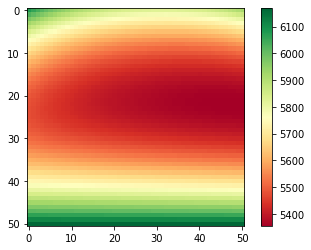

In [86]:
nb_points_mesh = 50
scores = np.zeros([nb_points_mesh+1, nb_points_mesh+1])
for i in range(nb_points_mesh+1):
    u1 = i/nb_points_mesh
    for j in range(nb_points_mesh+1):
        u2 = j/nb_points_mesh
        f = g.simulation_one_player(x0, nb_iteration, time_step, lambda x, y: dummy_controller(x, y, u1, u2), [6])
        scores[i][j] = get_cost(f)
    if i % (nb_points_mesh/10) == 0:
        print(str(i*100 / nb_points_mesh) + " % done")
#         break
#     break

plt.imshow(scores, cmap='RdYlGn', interpolation='none')
plt.colorbar()
plt.show()

----- Greedy controller -----


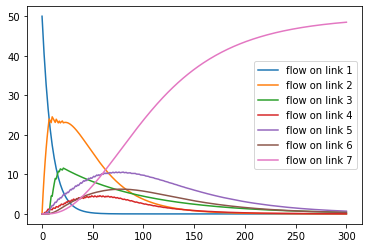

Cost: 5429.879861444365
----- Brute force controller -----


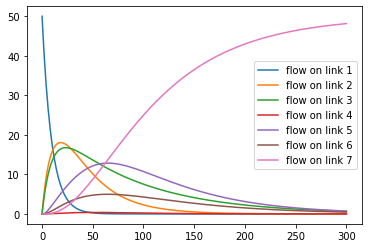

Cost: 5355.281157531924


In [87]:
print("----- Greedy controller -----")
f_greedy = g.simulation_one_player(x0, nb_iteration, time_step, greedy_controller, [6])


g.plot_flow(f_greedy)
print("Cost: " + str(get_cost(f_greedy)))

print("----- Brute force controller -----")
u1, u2 = np.unravel_index(scores.argmin(), scores.shape)
u1 = u1 / nb_points_mesh
u2 = u2 / nb_points_mesh
f_brute_force = g.simulation_one_player(x0, nb_iteration, time_step, lambda x, y: dummy_controller(x, y, u1, u2), [6])
g.plot_flow(f_brute_force)
print("Cost: " + str(get_cost(f_brute_force)))


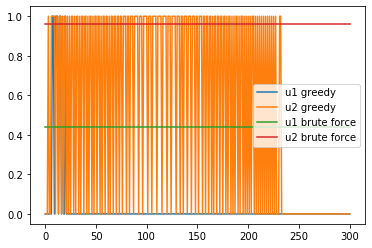

In [88]:
nb_points = f_greedy.shape[0]
u1_greedy = np.zeros(nb_points)
u2_greedy = np.zeros(nb_points)
u1_brute = np.ones(nb_points)*u1
u2_brute = np.ones(nb_points)*u2

for i in range(nb_points):
    matrix = greedy_controller(g, f_greedy[i, :])
    u1_greedy[i] = matrix[0][2]
    u2_greedy[i] = matrix[1][4]
    
plt.plot(u1_greedy, label="u1 greedy")
plt.plot(u2_greedy, label="u2 greedy")
plt.plot(u1_brute, label="u1 brute force")
plt.plot(u2_brute, label="u2 brute force")
plt.legend()
plt.show()

Greedy


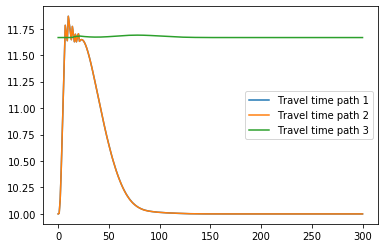

Brut force


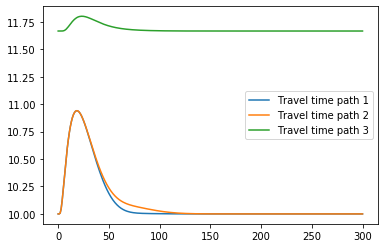

In [89]:
def get_travel_time(g, x):
    travel_time = np.zeros((x.shape[0], 3))
    for i in range(x.shape[0]):
        tt = g.get_mean_travel_time(x[i, :])
        travel_time[i] = [tt[1] + tt[3] + tt[5], tt[1] + tt[4], tt[2] + tt[5]]
        
    return travel_time


print("Greedy")
travel_time = get_travel_time(g, f_greedy)
plt.plot(travel_time[:,0], label="Travel time path 1")
plt.plot(travel_time[:,1], label="Travel time path 2")
plt.plot(travel_time[:,2], label="Travel time path 3")
plt.legend()
plt.show()

print("Brut force")
travel_time = get_travel_time(g, f_brute_force)
plt.plot(travel_time[:,0], label="Travel time path 1")
plt.plot(travel_time[:,1], label="Travel time path 2")
plt.plot(travel_time[:,2], label="Travel time path 3")
plt.legend()
plt.show()



<IPython.core.display.Javascript object>


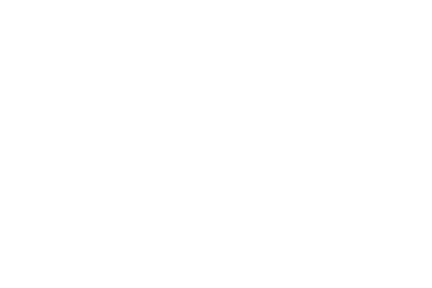

<IPython.core.display.Javascript object>


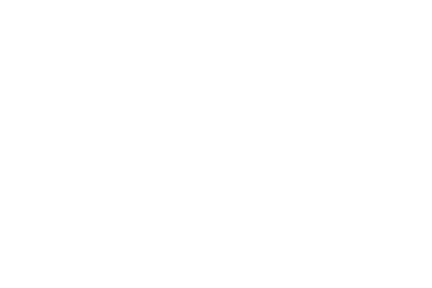

Traceback (most recent call last):
  File "/Users/theophile/miniconda3/envs/dev/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/Users/theophile/miniconda3/envs/dev/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [35]:
# showing the simulation
%matplotlib notebook
# %matplotlib inline
import matplotlib.animation as animation

f = f_greedy

links = np.zeros((g.nb_links, 4))
for i in range(g.nb_links):
    links[i,:2] = g.graph[g.connections[i,0]]["location"]
    links[i,2:] = g.graph[g.connections[i,1]]["location"]

cdict = {'red': (1.0, 0.0, 0.0), 'green': (0.0, 1.0, 0.0)}

fig, ax = plt.subplots()
ln = []
for i in range(g.nb_links):
#     print(i)
    ln.append(plt.quiver(links[i, 0], links[i, 1], links[i, 2]-links[i, 0], links[i, 3]-links[i, 1], color="b", angles='xy', scale_units='xy', scale=1))
#     plt.quiver(links[i, 0], links[i, 1], links[i, 2]-links[i, 0], links[i, 3]-links[i, 1], color="b", angles='xy', scale_units='xy', scale=1)
plt.xlim([-0.5, 4.5])
plt.ylim([-1.5, 1.5])

def init():
    return ln,

def update(frame):
    c = np.array([(1-f[frame]/50)**2 * cdict["green"][i] + (f[frame]/50) * cdict["red"][i] for i in range(3)]).T
    for i in range(7):
        ln[i].set_color(c[i])
    return ln,

ani = animation.FuncAnimation(fig, update, frames = 200,
                    init_func=init, blit=True)
plt.show()

# # Set up formatting for the movie files
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=600)

# ani.save('test_simulation_2.mp4', writer=writer)
